# Import packages

In [1]:
######## Segmentation #############
from som_plus.segmentation_pipeline import SegmentationPipelineFactory
from transformers import AutoImageProcessor, MaskFormerForInstanceSegmentation, MaskFormerImageProcessor
from som_plus.augmentation import augment_annotations_parallel
from som_plus.gemini_vlm_query import perform_visual_grounding, perform_gqa
######## GEMINI ###########

import google.generativeai as genai
from dotenv import load_dotenv
import os

load_dotenv("/home/iliab/rice/final_project/.env")
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))


######## SAM2 ###########

import sys

sys.path.append("/home/iliab/rice/final_project/packages/sam2/") #path to sam2 package
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


######### other ###########

from PIL import Image
from ast import literal_eval

/home/iliab/miniconda3/envs/som_plus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Demo Example

## Define Image and Question

In [2]:
image_path = "/home/iliab/rice/final_project/refcocog_dataset/selected_data/val_images_250/45464.jpg"
visual_grounding_question = "Where is the woman in green jacket?"
gqa_question = "What is the color of pants that the woman in green is wearing?"

## Define the segmentation model

In [3]:

checkpoint = "/home/iliab/rice/final_project/packages/sam2/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2 = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

sam2_config = {
    "grid_stride": 50,
    "threshold": 0.8,
    "mask_area_threshold": 0.5,
    "mask_fill_alpha": 0.05,
    "mask_border_thickness": 2,
    "remove_small": True,
    "area_thresh": 100,
    "remove_mode": "islands",
    "iou_thresh": 0.7,
    "contain_thresh": 0.75,
    "refine_boundaries": True,
    "overlap_threshold": 0.2
}

sam2_pipeline = SegmentationPipelineFactory.create_pipeline(
    model_type="sam2",
    model=sam2,
    config=sam2_config
)

In [4]:
maskformer_model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-coco")
maskformer_processor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-large-coco")

maskformer_config = {
    "threshold": 0.95,
    "mask_area_threshold": 0.9,
    "mask_fill_alpha": 0.05,
    "mask_border_thickness": 2,
    "remove_small": True,
    "area_thresh": 100,
    "remove_mode": "islands"
}

# Create MaskFormer pipeline
maskformer_pipeline = SegmentationPipelineFactory.create_pipeline(
    model_type="maskformer",
    model=maskformer_model,
    processor=maskformer_processor,
    config=maskformer_config
)

/home/iliab/miniconda3/envs/som_plus/lib/python3.10/site-packages/transformers/utils/deprecation.py:172: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)
/home/iliab/miniconda3/envs/som_plus/lib/python3.10/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `MaskFormerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


## Perform segmentation

`label_ids_to_fuse` unset. No instance will be fused.


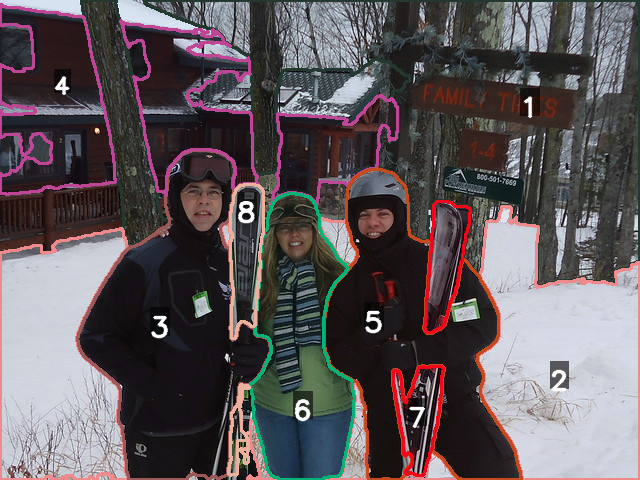

In [5]:
image = Image.open(image_path).convert("RGB")
annotated_image, annotations = maskformer_pipeline.segment_and_annotate(image)
annotated_image

## Augment annotations

In [6]:
augmented_annotations = augment_annotations_parallel(
    pipeline = maskformer_pipeline,
    image = image,
    annotations = annotations,
    grayscale_background = True, #grayscale non target annotations
    max_workers=10 #number of parallel workers
)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:02<00:00,  3.48it/s]


## Query vlm to perform visual grounding

In [7]:
descriptions = [i['description'] for i in augmented_annotations]

In [11]:
annotation_id, prompt = perform_visual_grounding(visual_grounding_question, image, descriptions, mode = 'parallel' )

Question:  Where is the woman in green jacket?
Answer:  6
Descriptions:  ['Annotation_ID_1:\n    Description: A sign with the words "FAMILY TH".\n    Relative location: Located in the upper right part of the image.\n    Color of the object inside annotation: Brown.\n    Texture / pattern: Woodgrain.\n    Pose / action: Displayed on a sign.\n    Number of similar objects in scene: 1\n    Unique distinguishing features: The sign appears to be made of wood.\n', 'Annotation_ID_2:\n    Description: A snow-covered surface with visible grasses sticking out.\n    Relative location: In the foreground of the image.\n    Color of the object inside annotation: White.\n    Texture / pattern: Textured due to the uneven surface of snow and visible grasses.\n    Pose / action: Snow is covering the ground.\n    Number of similar objects in scene: Multiple similar surfaces in the background.\n    Unique distinguishing features: The presence of grasses breaking through the snow layer.\n', 'Annotation_ID_

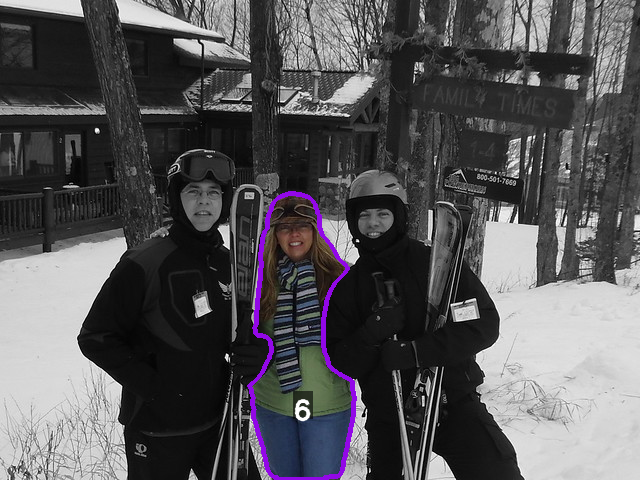

In [13]:
print("Question: ", visual_grounding_question)
print("Answer: ", annotation_id)
print("Descriptions: ", descriptions)
maskformer_pipeline.visualize_single_annotation(image = image, annotations=augmented_annotations, label_index=annotation_id)

## Query vlm to perform VQA

In [15]:
final_answer, variations, full_response = perform_gqa(gqa_question,annotated_image, descriptions,platform=None, mode = 'parallel' )

Question:  What is the color of pants that the woman in green is wearing?
Answer:  blue
Variations:  ['blues', 'azure', 'sapphire', 'cerulean', 'cobalt']
Full response:  Reasoning:Annotation_ID_6 describes a woman wearing green. The metadata mentions she is wearing blue, green, and brown clothing.  The image shows she is wearing blue pants.

Final Answer: "blue"
Final Answer Variations: ['blues', 'azure', 'sapphire', 'cerulean', 'cobalt']



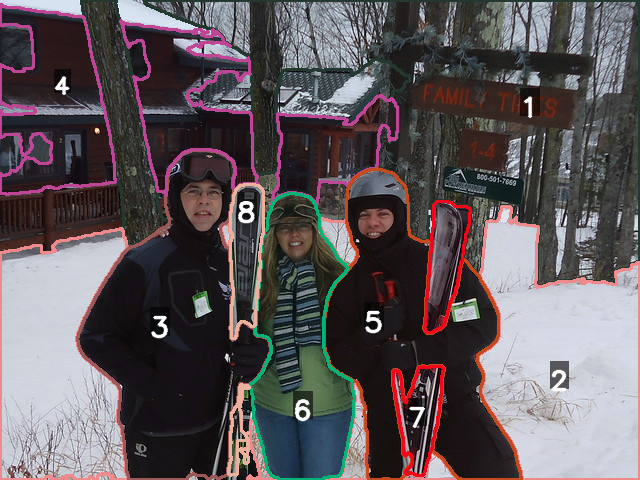

In [16]:
print("Question: ", gqa_question)
print("Answer: ", final_answer)
print("Variations: ", variations)
print("Full response: ", full_response)
annotated_image